In [9]:
import torch 
from torch import nn 
from torch.utils.data import DataLoader 
from torchvision import datasets 
from torchvision.transforms import ToTensor 
import matplotlib.pyplot as plt
import time 
import torch.nn.utils.spectral_norm as spectral_norm

In [7]:
train_dataset = datasets.FashionMNIST(
    root = 'data',
    train = True,
    download = False,
    transform = ToTensor()
)

test_dataset = datasets.FashionMNIST(
    root = 'data',
    train = False,
    download = False,
    transform = ToTensor()
)

train_dataloader = DataLoader(train_dataset, batch_size = 64)
test_dataloader = DataLoader(test_dataset, batch_size = 64)

device = 'cuda'

In [72]:
BATCH_SIZE = 64 
LEARNING_RATE = 2e-4
N_EPOCHS = 10
LEAKY_SLOPE = 0.2
B1_MOMENTUM = 0.5
Z_DIM = 100 
IMAGE_DIM = 28 * 28
HIDDEN_DIM = 128
N_CHANNELS = 1
D_ITER = 5


In [8]:
class Generator(nn.Module):
    def __init__(self, z_dim = Z_DIM, h_dim = HIDDEN_DIM, x_dim = IMAGE_DIM):
        super().__init__()
        self.fc = nn.Linear(z_dim, h_dim * 7 * 7)
        self.gen_stack = nn.Sequential(
            nn.ConvTranspose2d(h_dim, h_dim // 2, kernel_size =4, stride = 2, padding = 1),
            nn.BatchNorm2d(h_dim // 2),
            nn.ReLU(),
            nn.ConvTranspose2d(h_dim // 2, N_CHANNELS, kernel_size = 4, stride = 2, padding = 1),
            nn.Tanh()
        )
        self._initialize_weights()

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), HIDDEN_DIM, 7, 7)
        x = self.gen_stack(x)
        return x

    def _initialize_weights(self):
        for module in self.modules():
            if isinstance(module, nn.ConvTranspose2d):
                nn.init.normal_(module.weight, 0., 0.02)
            elif isinstance(module, nn.BatchNorm2d):
                nn.init.normal_(module.weight, 0., 0.02)
                nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, 0., 0.02)
                nn.init.constant_(module.bias, 0)
            

torch.Size([64, 1, 28, 28])


In [34]:
def gradient_penalty(discriminator, generator, real_data, fake_data):
    batch_size, c, h, w = real_data.shape
    eps = torch.randn((batch_size, 1, 1, 1)).repeat(1, c, h, w).to(device)
    interpolated_image = eps*real_data + (1 - eps)*fake_data

    interpolated_score = discriminator(interpolated_image)
    interpolated_gradients = torch.autograd.grad(
        inputs = interpolated_image,
        outputs = interpolated_score,
        grad_outputs = torch.ones_like(interpolated_score),
        create_graph = True,
        retain_graph = True
    )[0]

    interpolated_gradients = interpolated_gradients.view(interpolated_gradients.shape[0], -1)
    gradients_norm = interpolated_gradients.norm(2, dim = 1)
    penalty_term = torch.mean((gradients_norm - 1)**2)
    return penalty_term 

In [55]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.disc_stack = nn.Sequential(
            # nn.Conv2d(N_CHANNELS, HIDDEN_DIM // 2, kernel_size = 4, stride = 2, padding = 1),
            # nn.InstanceNorm2d(HIDDEN_DIM // 2),
            # nn.LeakyReLU(LEAKY_SLOPE),
            # nn.Conv2d(HIDDEN_DIM // 2, HIDDEN_DIM, kernel_size = 4, stride = 2, padding = 1),
            # nn.InstanceNorm2d(HIDDEN_DIM),
            # nn.LeakyReLU(LEAKY_SLOPE)
            spectral_norm(nn.Conv2d(N_CHANNELS, HIDDEN_DIM // 2, kernel_size = 4, stride = 2, padding = 1)),
            nn.InstanceNorm2d(HIDDEN_DIM // 2),
            nn.LeakyReLU(LEAKY_SLOPE),
            spectral_norm(nn.Conv2d(HIDDEN_DIM // 2, HIDDEN_DIM, kernel_size = 4, stride = 2, padding = 1)),
            nn.InstanceNorm2d(HIDDEN_DIM),
            nn.LeakyReLU(LEAKY_SLOPE)
        )
        self.fc = nn.Linear(HIDDEN_DIM * 7 * 7, 1)
        self._initialize_weights()

    def forward(self, x):
        x = self.disc_stack(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def _initialize_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.normal_(module.weight, 0., 0.02)
            elif isinstance(module, nn.BatchNorm2d):
                nn.init.normal_(module.weight, 0., 0.02)
                nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, 0., 0.02)
                nn.init.constant_(module.bias, 0)


In [81]:
gen_losses_avg = []
disc_losses_avg = []

def plot_images(generator, epoch, fixed_noise):
    generator.eval()
    fake_images = generator(fixed_noise).detach().cpu()
    fig = plt.figure(figsize = (8, 8))
    for i in range(64):
        plt.subplot(8, 8, i + 1)
        plt.imshow(fake_images[i][0], cmap = 'gray')
        plt.axis('off')
    plt.show()
    generator.train()

def plot_losses(gen_losses, disc_losses, n_batches_per_epoch):
    # Calculate the average loss per epoch
    gen_loss_avg = [sum(gen_losses[i:i + n_batches_per_epoch]) / n_batches_per_epoch for i in range(0, len(gen_losses), n_batches_per_epoch)]
    disc_loss_avg = [sum(disc_losses[i:i + n_batches_per_epoch]) / n_batches_per_epoch for i in range(0, len(disc_losses), n_batches_per_epoch)]
    
    plt.plot(gen_loss_avg, label='Generator loss')
    plt.plot(disc_loss_avg, label='Discriminator loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Generator and Discriminator Loss per Epoch')
    plt.show()


In [82]:
g_losses = []
d_losses = []
gen_losses_avg = []
disc_losses_avg = []
epoch = 0
def train_loop(dataloader, generator, discriminator, g_optimizer, d_optimizer, loss_fn):
    
    for batch, (X, _) in enumerate(dataloader):
        X = X.to(device)
        batch_size = X.size(0)
        z = torch.randn(batch_size, Z_DIM).to(device)
        for _ in range(D_ITER):
            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            fake_images = generator(z)
            fake_preds = discriminator(fake_images)

            gp = gradient_penalty(discriminator, generator, X, fake_images)

            real_preds = discriminator(X)

            d_loss = (
                -(torch.mean(real_preds) - torch.mean(fake_preds)) + 10*gp
            )

            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()
            d_losses.append(d_loss.item())
        

        #train generator 
        g_optimizer.zero_grad()
        z = torch.randn(batch_size, Z_DIM).to(device)
        fake_images = generator(z)
        fake_preds = discriminator(fake_images).reshape(-1)
        g_loss = -torch.mean(fake_preds)

        g_losses.append(g_loss.item())
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        if batch % 100 == 0:
            print(f'Generator Loss: {g_loss.item()} Discriminator Loss: {d_loss.item()}')

    
    

Generator Loss: -1.1066800355911255 Discriminator Loss: 1873.262451171875
Generator Loss: 5.27154541015625 Discriminator Loss: -3.3109889030456543
Generator Loss: 4.544679164886475 Discriminator Loss: -2.652454376220703
Generator Loss: 4.019793510437012 Discriminator Loss: -1.4441242218017578
Generator Loss: 3.2598671913146973 Discriminator Loss: -3.8483221530914307
Generator Loss: 4.836018085479736 Discriminator Loss: -3.7716097831726074
Generator Loss: 4.321797847747803 Discriminator Loss: -3.4377920627593994
Generator Loss: 4.2975263595581055 Discriminator Loss: -4.045675277709961
Generator Loss: 3.0556344985961914 Discriminator Loss: -3.3801000118255615
Generator Loss: 2.205528736114502 Discriminator Loss: -3.535435199737549
Epoch 1/10 took 135.69s


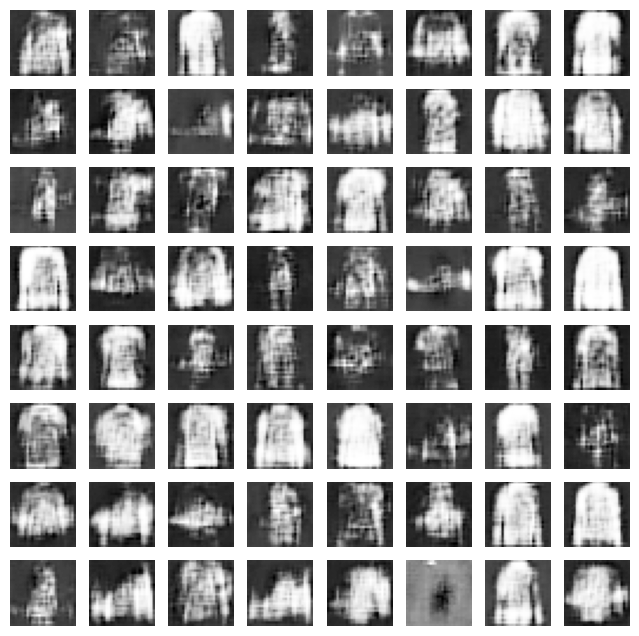

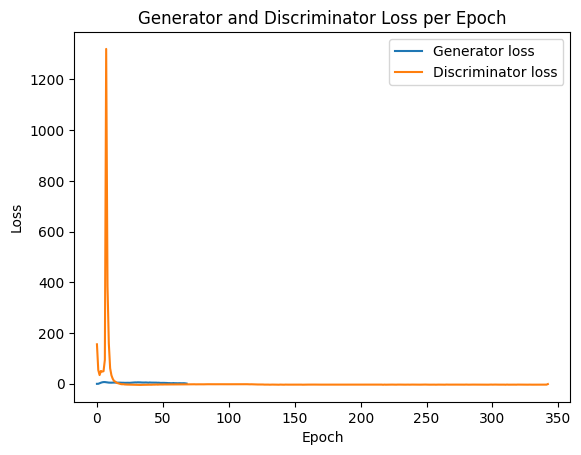

Generator Loss: 1.7097285985946655 Discriminator Loss: -4.005795955657959
Generator Loss: 2.8161959648132324 Discriminator Loss: -3.566693067550659
Generator Loss: 1.7597274780273438 Discriminator Loss: -3.3830904960632324
Generator Loss: 2.1993656158447266 Discriminator Loss: -3.2255494594573975
Generator Loss: 1.5186054706573486 Discriminator Loss: -3.422321319580078
Generator Loss: 1.5571863651275635 Discriminator Loss: -3.073941707611084
Generator Loss: 3.207123279571533 Discriminator Loss: -3.3877334594726562
Generator Loss: 1.3419499397277832 Discriminator Loss: -3.2306861877441406
Generator Loss: 0.13410601019859314 Discriminator Loss: -3.1251745223999023
Generator Loss: 0.5588968396186829 Discriminator Loss: -3.0363988876342773
Epoch 2/10 took 122.32s


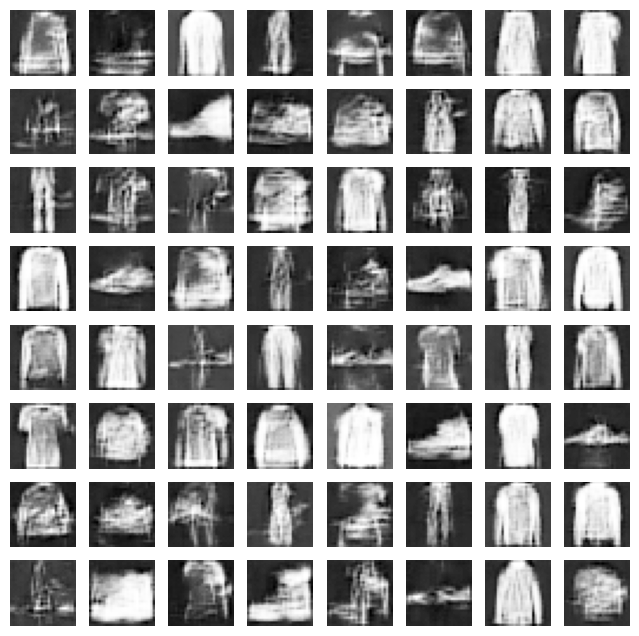

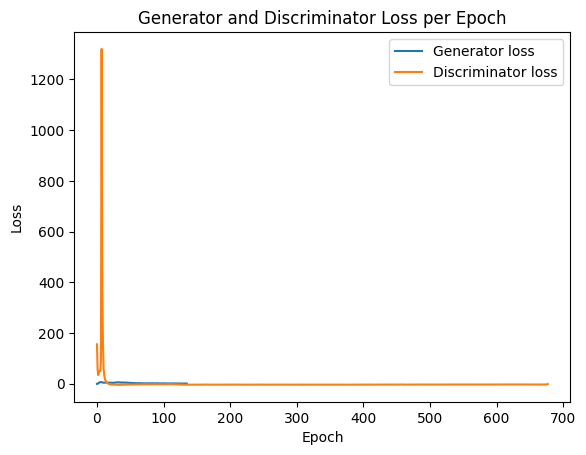

Generator Loss: 1.332279920578003 Discriminator Loss: -3.404707431793213
Generator Loss: 2.472438097000122 Discriminator Loss: -3.0420665740966797
Generator Loss: 0.20255982875823975 Discriminator Loss: -2.95693302154541
Generator Loss: 2.212390184402466 Discriminator Loss: -2.7320802211761475
Generator Loss: 0.45936137437820435 Discriminator Loss: -3.2482876777648926
Generator Loss: 0.29448840022087097 Discriminator Loss: -2.657167434692383
Generator Loss: 2.648560047149658 Discriminator Loss: -2.9128921031951904
Generator Loss: 0.6227001547813416 Discriminator Loss: -2.9689013957977295
Generator Loss: -0.3714520037174225 Discriminator Loss: -3.1267683506011963
Generator Loss: -0.3898402154445648 Discriminator Loss: -2.637274980545044
Epoch 3/10 took 119.55s


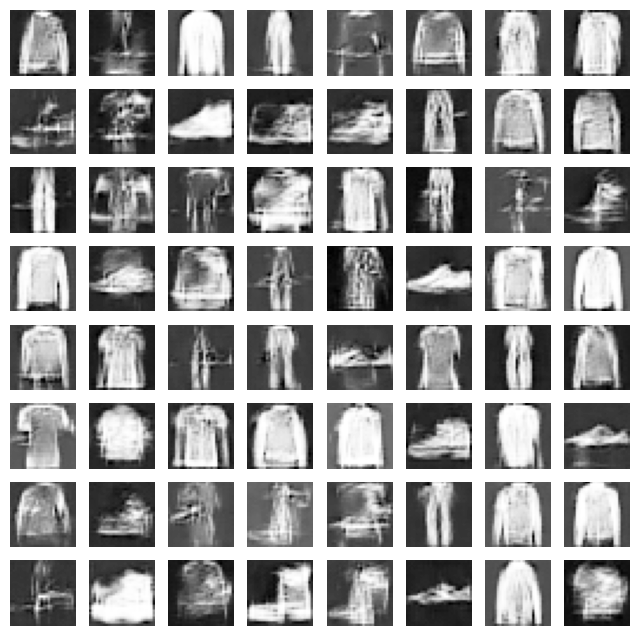

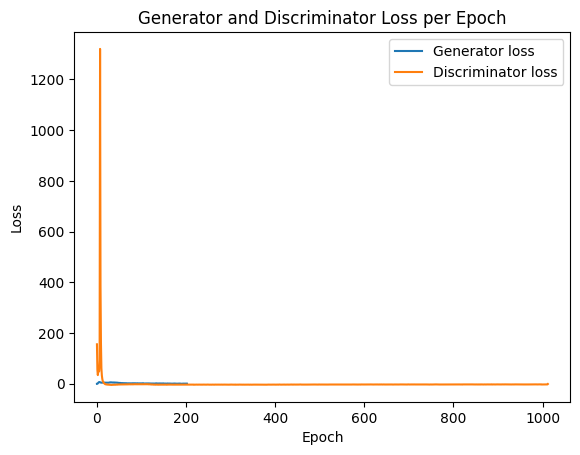

Generator Loss: 0.23895332217216492 Discriminator Loss: -2.6957263946533203
Generator Loss: 1.9285110235214233 Discriminator Loss: -3.20294189453125
Generator Loss: -0.9772295951843262 Discriminator Loss: -3.072373151779175
Generator Loss: 0.91834557056427 Discriminator Loss: -2.4629251956939697
Generator Loss: 0.6094284057617188 Discriminator Loss: -3.010941505432129
Generator Loss: -0.885275661945343 Discriminator Loss: -2.8607399463653564
Generator Loss: 1.6919810771942139 Discriminator Loss: -2.9314231872558594
Generator Loss: -0.2820240259170532 Discriminator Loss: -2.84800124168396
Generator Loss: -1.3516590595245361 Discriminator Loss: -3.1381843090057373
Generator Loss: -0.5721250772476196 Discriminator Loss: -2.4758799076080322
Epoch 4/10 took 146.77s


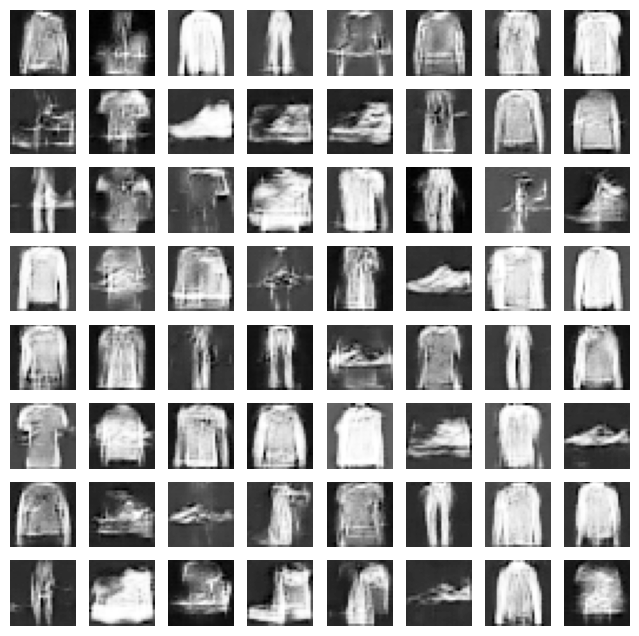

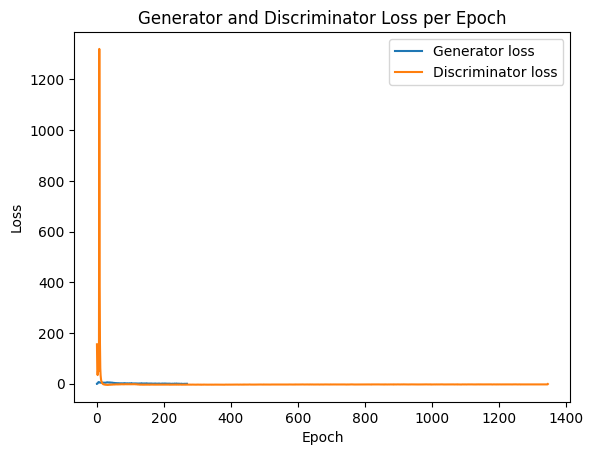

Generator Loss: -1.5217736959457397 Discriminator Loss: -2.3740029335021973
Generator Loss: 0.8095830678939819 Discriminator Loss: -2.628652572631836
Generator Loss: -0.6697497367858887 Discriminator Loss: -2.7050557136535645
Generator Loss: -0.06035962700843811 Discriminator Loss: -2.676283359527588
Generator Loss: 0.22007842361927032 Discriminator Loss: -2.902495861053467
Generator Loss: -1.655484676361084 Discriminator Loss: -3.126528024673462
Generator Loss: 0.8797628283500671 Discriminator Loss: -2.8257346153259277
Generator Loss: -0.8137339353561401 Discriminator Loss: -3.020069122314453
Generator Loss: -1.0136746168136597 Discriminator Loss: -2.8053619861602783
Generator Loss: -0.9440031051635742 Discriminator Loss: -2.538158416748047
Epoch 5/10 took 126.63s


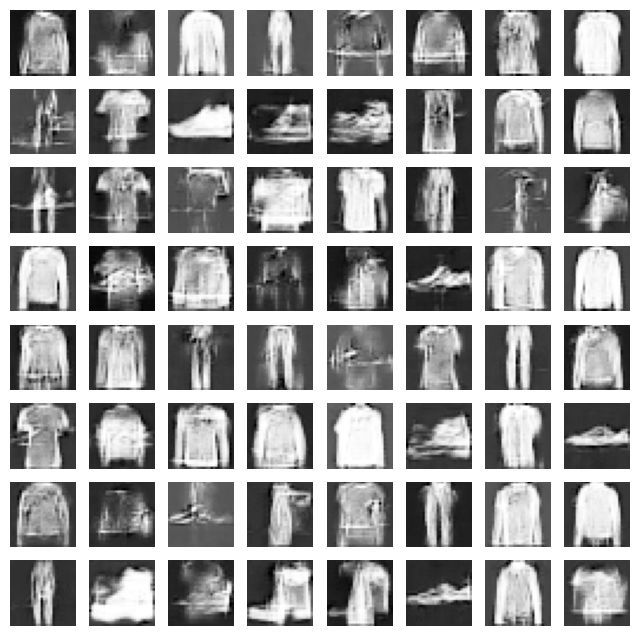

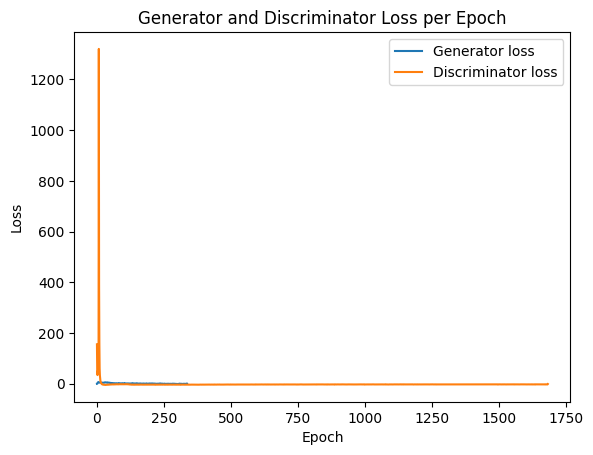

Generator Loss: -0.4974454939365387 Discriminator Loss: -2.7805938720703125
Generator Loss: 0.32374849915504456 Discriminator Loss: -2.8085250854492188
Generator Loss: -1.3938233852386475 Discriminator Loss: -2.691218137741089
Generator Loss: 1.1204757690429688 Discriminator Loss: -2.7014496326446533
Generator Loss: 0.1053718626499176 Discriminator Loss: -3.2835750579833984
Generator Loss: 0.4896750748157501 Discriminator Loss: -2.598527431488037
Generator Loss: 1.3294817209243774 Discriminator Loss: -2.67960786819458
Generator Loss: -0.18744294345378876 Discriminator Loss: -2.49120831489563
Generator Loss: -0.3682467043399811 Discriminator Loss: -2.913102149963379
Generator Loss: -2.0102379322052 Discriminator Loss: -2.485225200653076
Epoch 6/10 took 137.10s


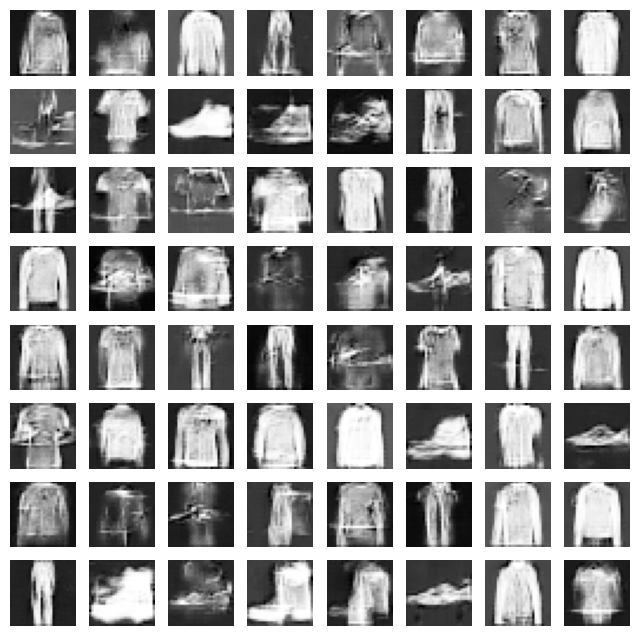

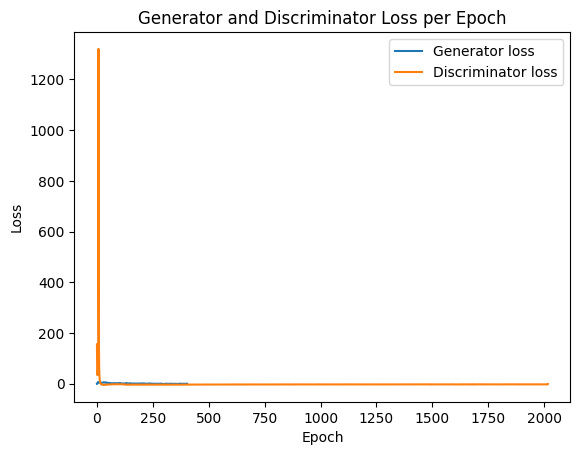

Generator Loss: -1.37412691116333 Discriminator Loss: -3.513690948486328
Generator Loss: 1.8931363821029663 Discriminator Loss: -2.805239200592041
Generator Loss: -1.467459797859192 Discriminator Loss: -2.5954384803771973
Generator Loss: -0.3196462094783783 Discriminator Loss: -2.8430662155151367
Generator Loss: -1.1184790134429932 Discriminator Loss: -3.4231038093566895
Generator Loss: -1.3397282361984253 Discriminator Loss: -2.577659845352173
Generator Loss: 0.9696638584136963 Discriminator Loss: -3.082101345062256
Generator Loss: -0.11908483505249023 Discriminator Loss: -2.55307936668396
Generator Loss: -2.110780715942383 Discriminator Loss: -2.6850790977478027
Generator Loss: -1.646133303642273 Discriminator Loss: -2.431556224822998
Epoch 7/10 took 139.97s


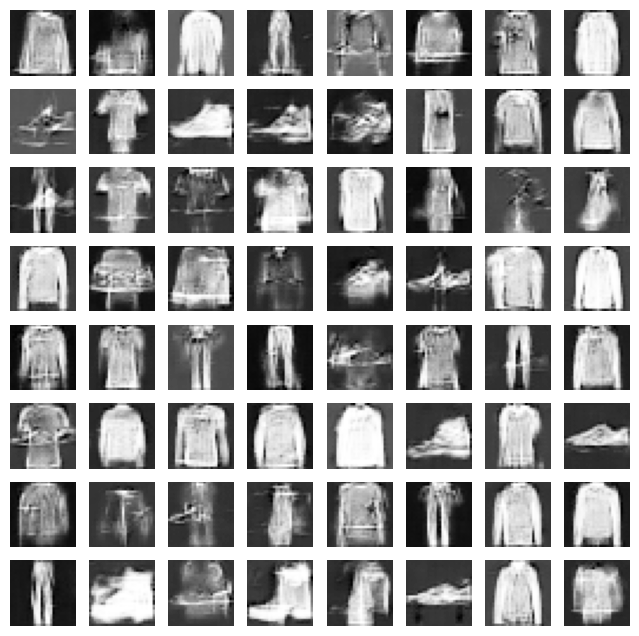

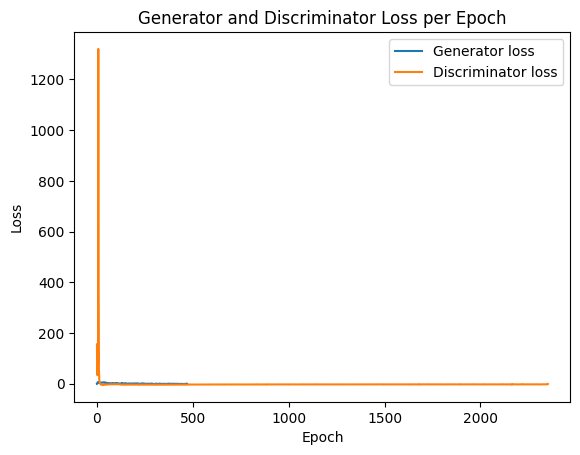

Generator Loss: -1.8285613059997559 Discriminator Loss: -2.7727322578430176
Generator Loss: -0.7708117961883545 Discriminator Loss: -2.4871931076049805
Generator Loss: -1.4689526557922363 Discriminator Loss: -2.6329407691955566
Generator Loss: -0.007186576724052429 Discriminator Loss: -2.270655632019043
Generator Loss: 0.037237927317619324 Discriminator Loss: -2.7733547687530518
Generator Loss: 0.559778094291687 Discriminator Loss: -2.5883188247680664
Generator Loss: 2.005279302597046 Discriminator Loss: -3.1958365440368652
Generator Loss: 0.622833251953125 Discriminator Loss: -2.8788504600524902
Generator Loss: -0.7747710347175598 Discriminator Loss: -2.9183871746063232
Generator Loss: -1.15596342086792 Discriminator Loss: -2.7029757499694824
Epoch 8/10 took 128.23s


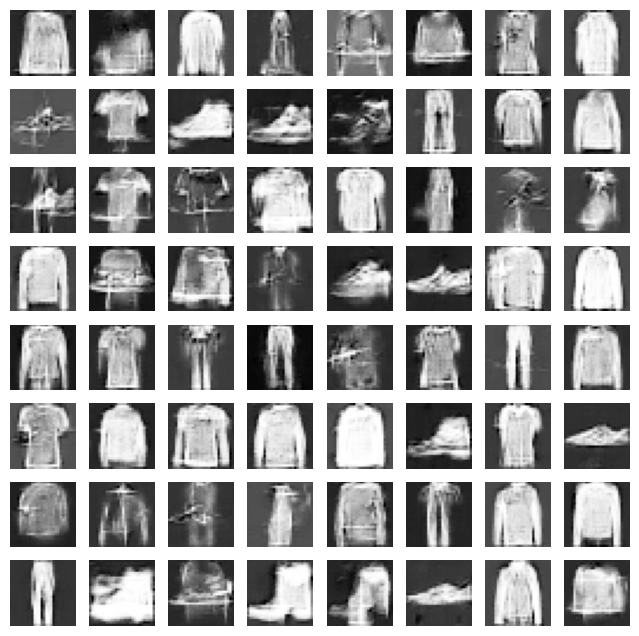

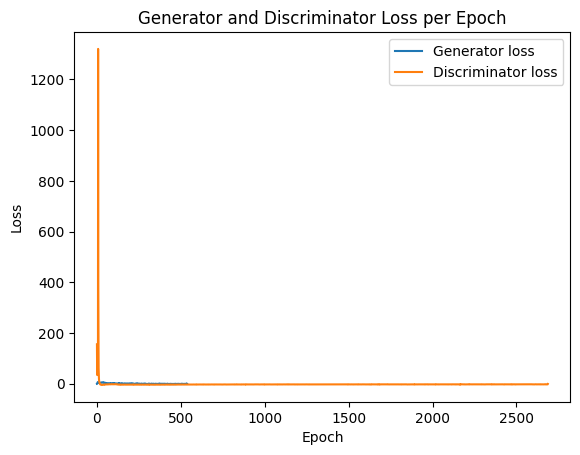

Generator Loss: -0.5465318560600281 Discriminator Loss: -2.3542275428771973
Generator Loss: -0.6533130407333374 Discriminator Loss: -1.993627667427063
Generator Loss: -0.914435625076294 Discriminator Loss: -2.7545382976531982
Generator Loss: 0.7572945952415466 Discriminator Loss: -2.4855594635009766
Generator Loss: 0.22012287378311157 Discriminator Loss: -3.6804680824279785
Generator Loss: -0.925147533416748 Discriminator Loss: -2.7159783840179443
Generator Loss: 1.3110688924789429 Discriminator Loss: -2.799799680709839
Generator Loss: 0.18152537941932678 Discriminator Loss: -2.5259642601013184
Generator Loss: -1.131805658340454 Discriminator Loss: -2.7167606353759766
Generator Loss: -0.4479091167449951 Discriminator Loss: -2.273045063018799
Epoch 9/10 took 138.94s


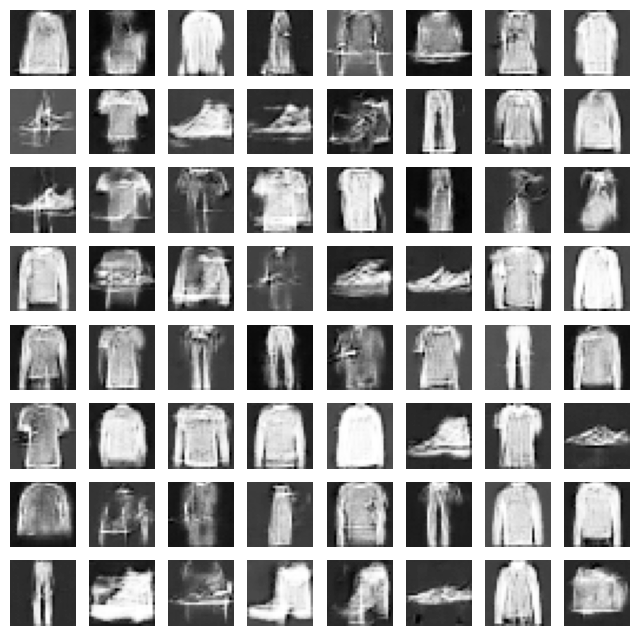

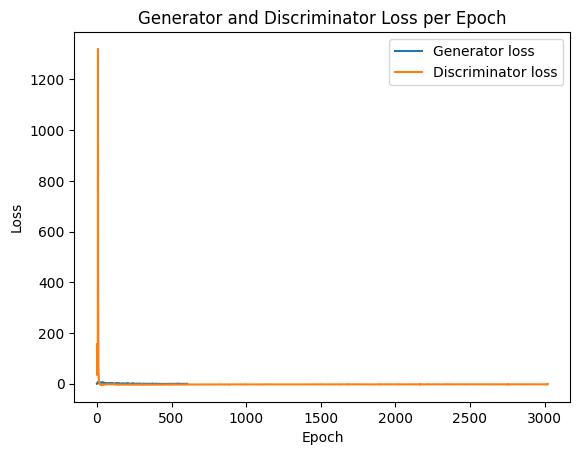

Generator Loss: -0.38841092586517334 Discriminator Loss: -2.4446704387664795
Generator Loss: 0.6010946035385132 Discriminator Loss: -2.857327461242676
Generator Loss: -1.1200273036956787 Discriminator Loss: -2.792851209640503
Generator Loss: 1.8493413925170898 Discriminator Loss: -2.608703851699829
Generator Loss: -1.333425521850586 Discriminator Loss: -2.9334962368011475
Generator Loss: -1.7882038354873657 Discriminator Loss: -2.7448654174804688
Generator Loss: 0.6546178460121155 Discriminator Loss: -2.4072062969207764
Generator Loss: 0.5851709842681885 Discriminator Loss: -2.5283377170562744
Generator Loss: -1.521290898323059 Discriminator Loss: -3.2195582389831543
Generator Loss: -0.06920090317726135 Discriminator Loss: -3.010103702545166
Epoch 10/10 took 115.89s


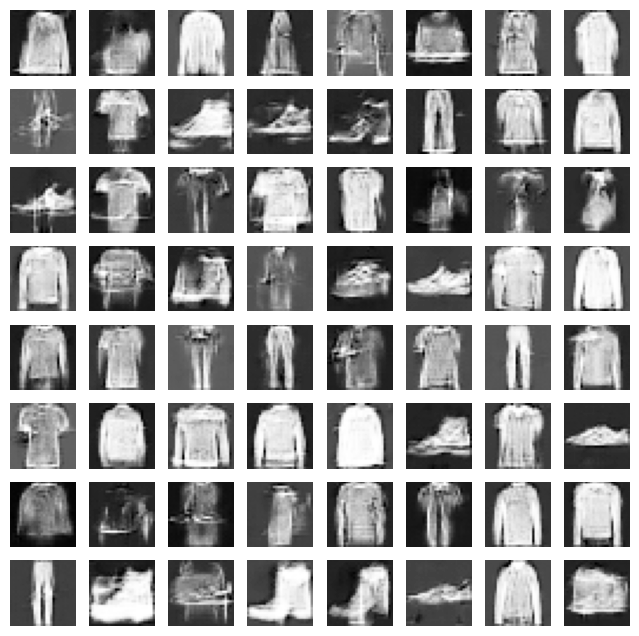

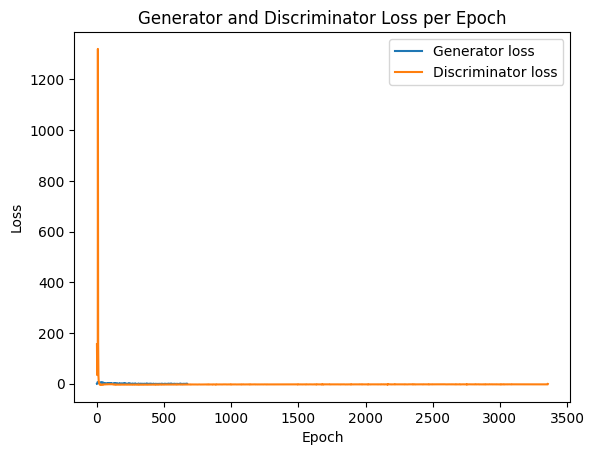

Training took 1319.62s


In [84]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

g_optimizer = torch.optim.Adam(generator.parameters(), lr = LEARNING_RATE, betas=(0., 0.9))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr = LEARNING_RATE, betas = (0., 0.9))

loss_fn = nn.BCEWithLogitsLoss()

fixed_noise = torch.randn(64, Z_DIM).to(device)

totaltime = time.time()
for epoch in range(N_EPOCHS):
    start = time.time()
    train_loop(train_dataloader, generator, discriminator, g_optimizer, d_optimizer, loss_fn)
    print(f'Epoch {epoch + 1}/{N_EPOCHS} took {time.time() - start:.2f}s')
    plot_images(generator, epoch, fixed_noise)
    plot_losses(g_losses, d_losses, len(train_dataloader) //  BATCH_SIZE)
    

print(f'Training took {time.time() - totaltime:.2f}s')
    